In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
tf.merge_all_summaries = tf.summary.merge_all
tf.train.SummaryWriter = tf.summary.FileWriter

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data = input_data.read_data_sets(".",one_hot = True)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [3]:
#add gaussian noise
train_images = data.train.images + np.random.normal(0, 0.05, (55000, 784))

In [4]:
def plot_images(img):
    plt.imshow(img.reshape(28,28),cmap="binary")
    plt.show()

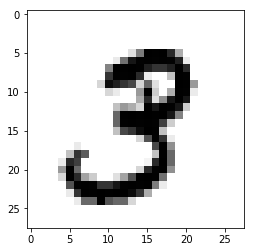

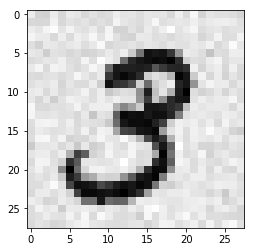

In [5]:
plot_images(data.train.images[1,:])
plot_images(train_images[1, :])

In [6]:
#computational graph for convolutional neural network
img = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(img, [-1, 28, 28, 1])

h11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x_image)
h12 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(h11)
h21 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(h12)
h22 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(h21)
h31 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(h22)
h32 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(h31)
h41 = tf.keras.layers.Conv2D(25, (3, 3), activation='relu', padding='same')(h32)
encoded = tf.keras.layers.MaxPool2D((2, 2), padding='same')(h41)
# the encoded image representation is (2, 2, 25) i.e. 100-dimensional

d01 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
d02 = tf.keras.layers.UpSampling2D((2, 2))(d01)
d11 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(d02)
d12 = tf.keras.layers.UpSampling2D((2, 2))(d11)
d21 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(d12)
d22 = tf.keras.layers.UpSampling2D((2, 2))(d21)
d31 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(d22)
d32 = tf.keras.layers.UpSampling2D((2, 2))(d31)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d32)

denoise = tf.reshape(decoded, [-1, 784])
origin = tf.placeholder(tf.float32, [None, 784])

In [45]:
loss = tf.reduce_mean(tf.norm(denoise - origin, axis=1))
optim = tf.train.GradientDescentOptimizer(learning_rate = 0.02).minimize(loss)

In [46]:
#running results for convolutional neural network
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
#Make batches to train
num_iter = 20000
batch_size = 256
loss_val = []
iteration = []
for i in range(num_iter):
    idx = np.random.choice(55000, [batch_size], False)
    batch_noise = train_images[idx][:]
    batch_origin = data.train.images[idx][:]
#     print(np.shape(batch_noise))
#     print(np.shape(batch_origin))
    _, l = sess.run([optim, loss],feed_dict = {img: batch_noise, origin: batch_origin})
    if i % 1000 == 0:
        print(l)

13.466874
5.990777
5.0298595
4.987724
4.8502703
4.4471083
4.5037823
4.382946
4.2210603
4.174017
4.1939597
4.713501
4.173565
4.1215944
4.143519
4.132949
4.148452
3.9507334
3.8343334
3.871192


original image


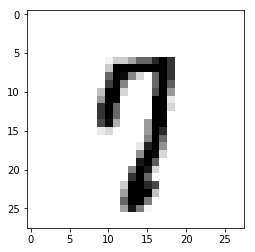

original image with noise


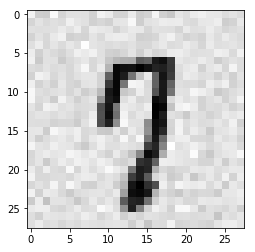

reconstructed image


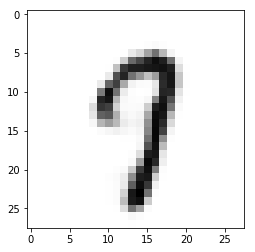

In [54]:
idx = [9999]
batch_noise = train_images[idx][:]
batch_origin = data.train.images[idx][:]
batch_denoise1 = sess.run([denoise],feed_dict = {img: batch_noise, origin: batch_origin})

print("original image")
plot_images(batch_origin[0, :])
print("original image with noise")
plot_images(batch_noise[0, :])
# print(np.shape(batch_denoise))
print("reconstructed image")
plot_images(batch_denoise1[0][0, :])
# print(np.linalg.norm(batch_origin[0, :]))

In [ ]:
def upsample_layer(bottom,
                       n_channels, name, upscale_factor):

        kernel_size = 2*upscale_factor - upscale_factor%2
        stride = upscale_factor
        strides = [1, stride, stride, 1]
        with tf.variable_scope(name):
            # Shape of the bottom tensor
            in_shape = tf.shape(bottom)

            h = ((in_shape[1] - 1) * stride) + 1
            w = ((in_shape[2] - 1) * stride) + 1
            new_shape = [in_shape[0], h, w, n_channels]
            output_shape = tf.stack(new_shape)

            filter_shape = [kernel_size, kernel_size, n_channels, n_channels]

            weights = get_bilinear_filter(filter_shape,upscale_factor)
            deconv = tf.nn.conv2d_transpose(bottom, weights, output_shape,
                                            strides=strides, padding='SAME')

        return deconv